## Knowledge Distillation
**Notebook created in PyTorch by [Laia Tarrés](https://github.com/santi-pdp) for [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2021).**

**Based on other notebooks that show distillation [1](https://colab.research.google.com/github/sayakpaul/Knowledge-Distillation-in-Keras/blob/master/Distillation_with_Transfer_Learning.ipynb#scrollTo=b1jE623hh781), [2](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/knowledge_distillation.ipynb), [3](https://colab.research.google.com/drive/1-yHSQTljXyca2aSFhpM2y4n9B4M-KWso#scrollTo=3JApQdNz19bT) for educational purposes**

# Introduction to Knowledge Distillation


Modern state-of-the-art neural network architectures are HUGE. 

Unfortunately, more is sometimes not better when it comes to the number of parameters. Sure, more parameters seem to mean better results, but also massive computational costs.

However, deploying much smaller models can also present a significant challenge for machine learning engineers. In practice, small and fast models are much better than massive ones.

Because of this, researchers and engineers have put significant energy into compressing models.

To optimize these costs by compressing the models, three main methods have emerged:

*   Weight pruning
*   Quantization
*   knowledge distillation


Today we will focus on Knowledge Distillation. Knowledge Distillation is a procedure for model compression, in which a small (student) model is trained to match a large pre-trained (teacher) model. 

Knowledge is transferred from the teacher model to the student by minimizing a loss function, aimed at matching teacher logits as well as ground-truth labels.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

# Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import random
import numpy as np
from timeit import default_timer as timer

import matplotlib.pyplot as plt

Define hparams and Select the GPU Hardware Acceleration in the Runtime environment Menu.

In [2]:
hparams = {
    'batch_size':4,
    'num_epochs':5,
    'test_batch_size':4,
    'num_classes':10,
    'learning_rate':1e-3, 
    'learning_rate_dist': 5e-3,
    'log_interval':2000,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
assert(hparams['device']=='cuda')

Let's define a few helper functions:

In [4]:
def plot_samples(images,N=5):
    # Randomly select NxN images and save them in ps
    ps = random.sample(range(0,images.shape[0]), N**2)
    # Allocates figure f divided in subplots contained in an NxN axarr
    # https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.subplots.html
    f, axarr = plt.subplots(N, N)
    # Index for the images in ps to be plotted
    p = 0
    # Scan the NxN positions of the grid
    for i in range(N):
        for j in range(N):
          
            # Load the image pointed by p
            im = images[ps[p]].transpose(1,2,0)
            axarr[i,j].imshow(im)
            # Remove axis
            axarr[i,j].axis('off')
            # Point to the next image from the random selection
            p+=1
    # Show the plotted figure         
    plt.show()

In [5]:
def get_param_count(model):
    param_counts = [np.prod(p.size()) for p in model.parameters()]
    return sum(param_counts)

In [6]:
class ConvBlock(nn.Module):

  def __init__(self, num_inp_channels, num_out_fmaps, 
               kernel_size, stride=1):
    super().__init__()
    self.kernel_size = kernel_size
    self.stride = stride
    self.conv = nn.Conv2d(num_inp_channels, num_out_fmaps, kernel_size,
                          stride=stride)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, x):
    P_ = self.kernel_size // 2
    if self.stride > 1:
      P = (P_ - 1, P_, P_  - 1, P_ )
    else:
      P = (P_, P_, P_, P_)
    x = self.conv(F.pad(x, P, mode='constant'))
    return self.relu(x)

In [7]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

In [8]:
def train_epoch(train_loader, network, optimizer, criterion, hparams, epoch):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  losses = []
  accs = []
  logsoftmax = nn.LogSoftmax(dim=-1)
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = logsoftmax(network(data))
      loss = criterion(output, target)
      loss.backward()
      acc = 100 * (correct_predictions(output, target) / data.shape[0])
      losses.append(loss.item())
      accs.append(acc)
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.1f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              np.mean(accs)))
  return np.mean(losses), np.mean(accs)

In [9]:
def eval_epoch(eval_loader, network, criterion, hparams):
    network.eval()
    device = hparams['device']
    eval_loss = 0
    acc = 0
    logsoftmax = nn.LogSoftmax(dim=-1)
    with torch.no_grad():
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            output = logsoftmax(network(data))
            eval_loss += criterion(output, target).item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    eval_loss /= len(eval_loader.dataset)
    eval_acc = 100. * acc / len(eval_loader.dataset)
    print('Eval set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        eval_loss, acc, len(eval_loader.dataset), eval_acc,
        ))
    return eval_loss, eval_acc

In [10]:
def train_net(network, train_loader, eval_loader, optimizer, criterion, num_epochs, plot=True):
  """ Function that trains and evals a network for num_epochs,
      showing the plot of losses and accs and returning them.
  """
  tr_losses = []
  tr_accs = []
  te_losses = []
  te_accs = []

  network.to(hparams['device'])

  for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_epoch(train_loader, network, optimizer, criterion, hparams, epoch)
    criterion_val = nn.NLLLoss(reduction='sum')
    te_loss, te_acc = eval_epoch(eval_loader, network, criterion_val, hparams)
    te_losses.append(te_loss)
    te_accs.append(te_acc)
    tr_losses.append(tr_loss)
    tr_accs.append(tr_acc)
  rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='train')
    plt.plot(te_losses, label='eval')
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Eval Accuracy [%]')
    plt.plot(tr_accs, label='train')
    plt.plot(te_accs, label='eval')
    plt.legend()
  return rets

In [11]:
def test_net(network, test_loader):
  network.to(hparams['device'])
  network.eval()
  device = hparams['device']
  eval_loss = 0
  acc = 0
  logsoftmax = nn.LogSoftmax(dim=-1)
  beg_t = timer()
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = logsoftmax(network(data))
          acc += correct_predictions(output, target)
  end_t = timer()
  train_time = end_t - beg_t 
  test_acc = 100. * acc / len(test_loader.dataset)
  print('Test set:  Accuracy: {}/{} ({:.0f}%) Time to test: {} seconds.'.format(
       acc, len(test_loader.dataset), test_acc,round(train_time),
      ))
  return test_acc

#Defining the dataloader for CIFAR-10

Using ``torchvision``, it's easy to load CIFAR10. 

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

val_size = 5000 #5000
train_size = len(dataset) - val_size #45000

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])


trainloader = torch.utils.data.DataLoader(train_ds, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_ds, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=hparams['batch_size'],
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's show a few examples from CIFAR-10:

Files already downloaded and verified


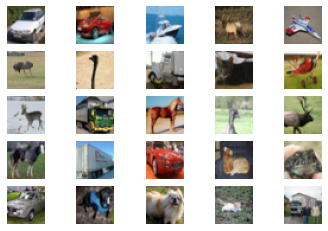

In [ ]:
#make a toy CIFAR sampleset without normalization for the sake of visualizing
# some samples
sampleset = torchvision.datasets.CIFAR10('data', train=True, download=True, 
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))
img = []
for n in range(50):
  img.append(sampleset[n][0][None, ...])
img = torch.cat(img, dim=0).data.numpy()
plot_samples(np.array(img))

# Training the small (student) network

----------------------------
We will do the following steps in order:
1. Define a Convolutional Neural Network
2. Define a loss function
3. Train the network on the training data
4. Test the network on the test data

In [ ]:
class SmallNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = ConvBlock(3, 128, 3, stride=4)
    self.conv2 = ConvBlock(128, 256, 3, stride=4)
    self.mlp = nn.Sequential(
        nn.Linear(256 * 2 * 2, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, hparams['num_classes'])#,nn.LogSoftmax(dim=-1)
    )
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    bsz, nch, height, width = x.shape
    x = x.view(bsz, -1)
    y = self.mlp(x)
    return y

In [ ]:
smallnet = SmallNet()
optimizer = optim.Adam(smallnet.parameters(), lr=hparams['learning_rate'])
criterion= nn.NLLLoss()
smallmodel_log = train_net(smallnet, trainloader, valloader, optimizer, criterion, hparams['num_epochs'])

Let's check how it performs on the test set and how much time it takes to infer this data:

In [ ]:
test_net(smallnet, testloader)

#Exercise 1: Compute the number of parameters from the small network

In [ ]:
#TODO: Check the helper functions and return the number of parameters of the smallnet
print('SmallNet number of params: ', ...)

# Let's define and load the teacher (*bigger*) model: Resnet


In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 819kB 17.9MB/s 
     |████████████████████████████████| 829kB 51.0MB/s 
     |████████████████████████████████| 112kB 52.7MB/s 
     |████████████████████████████████| 276kB 53.2MB/s 
     |████████████████████████████████| 1.3MB 47.9MB/s 
     |████████████████████████████████| 296kB 40.7MB/s 
     |████████████████████████████████| 143kB 56.8MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=095d66cd0d9ea64889687f7ad710bf61255d452074ba673a47a3a1f95031fb09
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=1e9b009bac7a499ba84a9f3dbde1130890b53b7fb3944b4dbcf6667efd0e979e
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
  

In [ ]:
import pytorch_lightning

We are going to use the model and weights from the following github:

In [ ]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 640 (delta 41), reused 50 (delta 22), pack-reused 552
Receiving objects: 100% (640/640), 6.59 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [ ]:
%cd PyTorch_CIFAR10

/content/PyTorch_CIFAR10


To download the weights for the CIFAR-10 dataset:

In [ ]:
!python train.py --download_weights 1

100% 979M/979M [01:22<00:00, 11.8MMiB/s]
Download successful. Unzipping file...
Unzip file successful!


In [ ]:
from cifar10_models.resnet import resnet50
resnet = resnet50(pretrained=True).to(hparams['device'])

Again, let's see how it performs on the test set and how long it takes to do inference:

In [ ]:
test_net(resnet, testloader)

#Exercise 2: Compute the number of parameters from the big network

In [ ]:
#TODO: Check the helper functions and return the number of parameters of the resnet
print('BigNet number of params: ',...) 

# Distilling the Resnet (teacher) into the convnet (student)

The idea here is to use the more granular continuous output from the `teacher` (the big ResNet) to aid the student while learning.

The loss function will thus have two parts: matching softened teacher logits + ground truth labels.

The logits are softened by applying a "temperature" scaling function in the softmax, effectively smoothing out the probability distribution and revealing inter-class relationships learned by the teacher.

#Exercise 3: Declare the student and teacher models

In [ ]:
#TODO: declare what will be the student and teacher models
student = ... #from scratch
teacher = ... #the one with the pretrained weights

#Exercise 4: Distill the teacher into the student model

In this example, we have two losses that are combined to obtain the loss that will be backpropagated in order to train the student. 

We have:


*   **Classification loss**: the typical loss: in this case, the network is outputing right before the softmax. To apply Category Cross Entropy, we have to apply first logsoftmax and then NLLLoss.
*   **Distillation loss**: in this loss, we are comparing the softened outputs from the softmax. As the model is outputing right before the softmax, we will have to apply the softmax with the corresponding temperature term and then MSELoss.



In [ ]:
def train_epoch_dist(train_loader, network_teacher, network_student, optimizer, criterion_hard, criterion_soft, hparams, epoch, alpha=0.5, temperature=1):
  # Activate the train=True flag inside the model
  network_student.train()
  device = hparams['device']
  losses = []
  accs = []
  logsoftmax = nn.LogSoftmax(dim=-1)
  softmax = nn.Softmax(dim=-1)
  beg_t = timer()
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output_student = network_student(data)
      output_teacher = network_teacher(data)
      #TO DO: define how the losses should be computed within training time
      #loss_class =  ... #TO DO
      #loss_dist =  ... #TO DO
      
      loss = alpha*(loss_class) + (1-alpha)*(loss_dist) 
      loss.backward()
      acc = 100 * (correct_predictions(logsoftmax(output_student), target) / data.shape[0])
      losses.append(loss.item())
      accs.append(acc)
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}\t Loss_class: {:.6f}, Loss_dist: {:.6f}\tAcc: {:.1f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(), loss_class.item(), loss_dist.item(),
              np.mean(accs)))
  end_t = timer()
  train_time = end_t - beg_t 
  print(f'Total train epoch: {round(train_time/60)} minutes.')
  return np.mean(losses), np.mean(accs)

def eval_epoch_dist(eval_loader, network, criterion,  hparams):
    network.eval()
    device = hparams['device']
    eval_loss = 0
    acc = 0
    logsoftmax = nn.LogSoftmax(dim=-1)
    with torch.no_grad():
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            output = logsoftmax(network(data))
            eval_loss += criterion(output, target).item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    eval_loss /= len(eval_loader.dataset)
    eval_acc = 100. * acc / len(eval_loader.dataset)
    print('Eval set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        eval_loss, acc, len(eval_loader.dataset), eval_acc,
        ))
    return eval_loss, eval_acc

def train_net_distillation(network_teacher, network_student, train_loader, eval_loader, optimizer, criterion_hard, criterion_soft, num_epochs, alpha=0.5, temperature=1, plot=True):
  """ Function that trains and evals a network for num_epochs,
      showing the plot of losses and accs and returning them.
  """
  tr_losses = []
  tr_accs = []
  te_losses = []
  te_accs = []

  network_teacher.to(hparams['device'])
  network_student.to(hparams['device'])

  for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_epoch_dist(train_loader, network_teacher, network_student, optimizer, criterion_hard, criterion_soft, hparams, epoch, alpha, temperature)
    criterion_hard_val = nn.NLLLoss(reduction='sum')
    te_loss, te_acc = eval_epoch_dist(eval_loader, network_student, criterion_hard,  hparams)
    te_losses.append(te_loss)
    te_accs.append(te_acc)
    tr_losses.append(tr_loss)
    tr_accs.append(tr_acc)
  rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='train')
    plt.plot(te_losses, label='eval')
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Eval Accuracy [%]')
    plt.plot(tr_accs, label='train')
    plt.plot(te_accs, label='eval')
    plt.legend()
  return rets

In [ ]:
alpha = 0.3 
temperature = 1

#TO DO: define the criterion for both terms of the loss function
criterion_hard = nn.
criterion_soft = nn....

optimizer = optim.SGD(student.parameters(), lr=hparams['learning_rate_dist'], momentum=0.9) #only modifying LR
distilledmodel_log_2= train_net_distillation(teacher, student, trainloader, valloader, optimizer, criterion_hard, criterion_soft, hparams['num_epochs']+1, alpha, temperature, plot=True)

Let's check how well (an fast) it's doing inference for the test set:

In [ ]:
test_net(student, testloader)

#Exercise 5 (Finale): Distill using the Temperature variable

First, let's do an example of how temperature scaling works

In [ ]:
import numpy as np
logits=np.array([1.,2.,3.,-1.])
print(f'Logits: {logits}')
logits_exp = np.exp(logits)
print(f'Logits exp: {logits_exp}')
logits_exp_normalized = np.exp(logits)/sum(np.exp(logits)) #this would be like applying the softmax
print(f'Logits exp normalized: {logits_exp_normalized}')

#Let's try with a few values of T:
T = [1.,5.,7.,10.]

for t in T:
  logits_exp_normalized_t = np.exp(logits/t)/sum(np.exp(logits/t))
  print(f'Temperature[{t}] - {logits_exp_normalized_t}')

Logits: [ 1.  2.  3. -1.]
Logits exp: [ 2.71828183  7.3890561  20.08553692  0.36787944]
Logits exp normalized: [0.08894682 0.24178252 0.65723302 0.01203764]
Temperature[1.0] - [0.08894682 0.24178252 0.65723302 0.01203764]
Temperature[5.0] - [0.22812574 0.2786334  0.34032361 0.15291725]
Temperature[7.0] - [0.23608545 0.27233991 0.31416179 0.17741285]
Temperature[10.0] - [0.24123681 0.2666079  0.2946473  0.19750799]


In [ ]:
#TO DO: declare the student again to start from scratch.
student = .. #TO DO

alpha = 0.3
temperature = 1.1
criterion_hard = nn.NLLLoss() 
criterion_soft = nn.MSELoss() 
optimizer = optim.SGD(student.parameters(), lr=hparams['learning_rate_dist'], momentum=0.9)
distilledmodel_log_2= train_net_distillation(teacher, student, trainloader, valloader, optimizer, criterion_hard, criterion_soft, hparams['num_epochs'], alpha, temperature, plot=True)

In [ ]:
test_net(student, testloader)

So here we see a modest (5% absolute) improvement over the directly supervised smaller model above. We have managed to distill signal from the soft targets provided by the very large ResNet model.

That said, there are many factors at play here and this is an oversimplified, didactic example. In practice, we would want play with the hyperparameters, try other losses, among other tricks. Still, the fundamental idea will remain the same!